# 2D pathing using PRM & A* Search Algorithm

Eureka Robotics Internship Application
by Gabriel James Goenawan

In [48]:
import pylab as pl
import numpy as np
import sys
from time import sleep
import random
sys.path.append('osr_course_pkgs/osr_examples/scripts/')
import environment_2d

## Plotting environment & generating random nodes

  Since We're generating a huge amount of points and thousands of connections, this part will take longer than usual.<br><br>
  `intersection_detector_resolution` - The lower the value, the less likely the path will goes through a thin <br>
  `max_nodes` - The total of random points generated (points generated is outside the obstacles to increase the                     chance of a valid path)<br>
  `max_distance_between_nodes` - The maximum distance between two nodes for a valid connection.<br>
  `nodes` - The list containing all nodes present<br>
  `valid_path` - The list containing all possible connection for each and every node. 
  
  `nodes` and `valid_path` are sequenced (e.g. element 0 is connections of node 0)
  <br><br>Note that `max_nodes` is copied to the A* Algorithm cell to ensure consistency. If you change the value here, please do change it at the bottom as well.
 
  

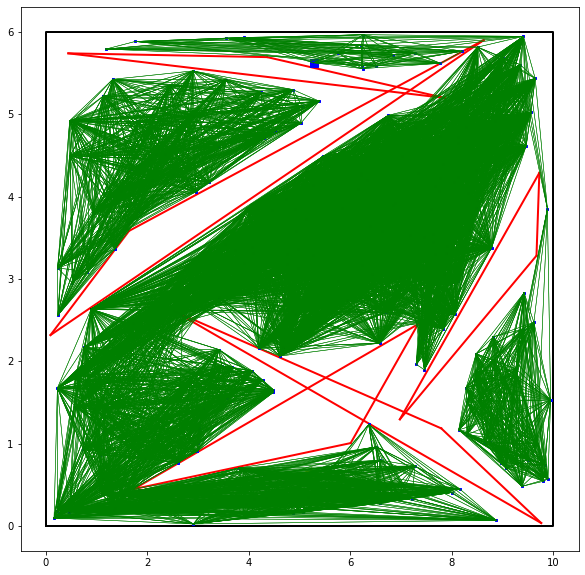

In [49]:
max_nodes = 250 # Change the one on the A* Algorithm Cell as well
max_distance_between_nodes = 3
intersection_detector_resolution = 100

def squared_distance(x0, y0, x1, y1):
    return ((x0-x1)**2)+((y0-y1)**2)

np.random.seed(4)
env = environment_2d.Environment(10, 6, 5)
pl.figure(figsize = (10,10))
pl.ion()
pl.clf()
env.plot()
q = env.random_query()
if q is not None:
  x_start, y_start, x_goal, y_goal = q
  env.plot_query(x_start, y_start, x_goal, y_goal)

#Generating random nodes
nodes = []

nodes.append([x_start, y_start])
for i in range (0, max_nodes):
    temp_x = random.uniform(0.0, 10.0)
    temp_y = random.uniform(0.0, 6.0)
    while env.check_collision(temp_x, temp_y):
        temp_x = random.uniform(0.0, 10.0)
        temp_y = random.uniform(0.0, 6.0)
    pl.plot(temp_x, temp_y, "bs", markersize = 2)
    nodes.append([temp_x, temp_y])
nodes.append([x_goal, y_goal])

#Finding Connections
max_distance_between_nodes_squared = max_distance_between_nodes **2
valid_paths = []
for i in range (0, max_nodes+2):
    available_connections = []
    for j in range (0, max_nodes+2):
        if j == i:
            continue
        distance_between_points = squared_distance(nodes[i][0], nodes[i][1], nodes[i][0], nodes[j][1])
        if (distance_between_points  > max_distance_between_nodes_squared):
            continue
        else: 
            path_collide = False
            for n in range (1,intersection_detector_resolution):
                #Intersection detector
                if env.check_collision(nodes[i][0]+(nodes[j][0]-nodes[i][0])*n/intersection_detector_resolution, nodes[i][1]+(nodes[j][1]-nodes[i][1])*n/intersection_detector_resolution):
                    path_collide = True
                    break
            if path_collide == False:
                available_connections.append([j, distance_between_points])
                pl.plot([nodes[i][0], nodes[j][0]], [nodes[i][1], nodes[j][1]] ,"g", linewidth=0.5)
    valid_paths.append(available_connections)

## A* Search Algorithm

A* is used because it is a complete and optimal search, yet it has relatively low complexity.<br>
Every node is placed into a `<node>` object, where its current_costs, coordinate, id, and parent are stored.<br>
A heuristic function that takes the euclidean distance (ignoring the obstacles) is used to guide the search aglorithm to further improve the efficiency of the search.

In [79]:
class node():
    def __init__(self, parent, node_id, coordinate_list, current_costs):
        self.parent = parent
        self.node_id = node_id
        self.current_costs = current_costs
        self.total_costs = current_costs + squared_distance(coordinate_list[0], coordinate_list[1], x_goal, y_goal)
    
    def __eq__(self, other):
        if other == None:
            return self.node_id == None
        else:
            return self.node_id == other.node_id

#Initiating Start and End Condition
max_nodes = 250 #A copy from above
start = node(None, 0, nodes[0], 0)
goal = node(None, max_nodes+1, nodes[max_nodes+1], 0)
open_list = [start]
closed_list = []
found_path = []
path_length = 0

#A* Algorithm
while len(open_list)>0:
    optimal_node_costs = None
    optimal_node = None
    for i in open_list:
        if optimal_node_costs == None or i.total_costs < optimal_node_costs:
            optimal_node_costs = i.total_costs
            current_node = i
    open_list.remove(current_node)
    closed_list.append(current_node)
    if current_node == goal:
        path_length = current_node.current_costs
        while current_node.parent != None :
            found_path.append(current_node.node_id)
            current_node = current_node.parent
        
        found_path.append(0)
        break
    else:
        for i in valid_paths[current_node.node_id]:
            child_node = node(current_node, i[0], nodes[i[0]], (current_node.current_costs + i[1]))
            if child_node not in closed_list:
                for j in open_list:
                    if child_node not in open_list and j==child_node and j.current_costs > child_node.current_costs:
                        open_list.append(child_node)
                if child_node not in open_list:
                    open_list.append(child_node)
                    
if len(found_path)>0:
    print("Optimal Path Found!")
else:
    print("Path not Found")

Optimal Path Found!


## Visualizing the result

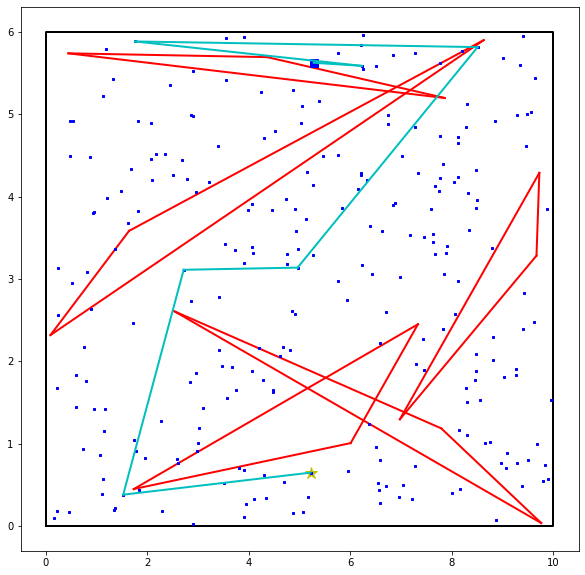

In [80]:
np.random.seed(4)
max_nodes = 20
env = environment_2d.Environment(10, 6, 5)
pl.figure(figsize = (10,10))
pl.ion()
pl.clf()
env.plot()
q = env.random_query()
if q is not None:
  x_start, y_start, x_goal, y_goal = q
  env.plot_query(x_start, y_start, x_goal, y_goal)
for i in nodes:
    pl.plot(i[0], i[1], "bs", markersize = 2)
    
# This section of the code is optional if you'd like to view all the vaid connection
#for i in range (0, len(valid_paths)):
#    for j in valid_paths[i]:
#        pl.plot([nodes[i][0], nodes[j[0]][0]], [nodes[i][1], nodes[j[0]][1]] ,"g", linewidth=0.5)

for i in range (1, len(found_path)):
    pl.plot([nodes[found_path[i-1]][0], nodes[found_path[i]][0]], [nodes[found_path[i-1]][1], nodes[found_path[i]][1]] ,"c", linewidth=2)

In [81]:
#Because the path tracing is from goal to start, it has to be reversed
found_path.reverse()

print(found_path)
print(path_length)

[0, 189, 192, 15, 218, 113, 38, 251]
14.791228090519345
